In [12]:
import os
import sys
import math
import random
import datetime
import logging
import pickle

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import pandas as pd
import numpy as np

import tensorflow_addons as tfa
from keras import Sequential, layers
from keras_cv_attention_models import efficientnet
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold

from PIL import Image as Img
import cv2 as cv

from ImageDataAugmentor.image_data_augmentor import *
from albumentations.core.composition import Compose, OneOf
from albumentations.core.transforms_interface import ImageOnlyTransform
import albumentations as A

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
devices = tf.config.list_physical_devices('GPU')
for device in devices:
   tf.config.experimental.set_memory_growth(device, True) 
print(devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [14]:
TASK = "sorghum-id"
TASK_ID = datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")

PATH = os.path.abspath(os.path.join(
os.getcwd(), "../../../../datasets/sorghum-id-fgvc-9"))+"/"

TRAIN_DIR = PATH+'train_images/'
TEST_DIR = PATH+'test/'

save_dir    = '../results/sorghum/'+TASK_ID+'/'
log_dir     = os.path.join("../logs/",''.join([TASK,"-",TASK_ID]))
model_dir   = os.path.join("../models/",''.join([TASK,"-",TASK_ID]))+'/'

In [15]:
NUM_GPUS = len(devices)

base_batch_size = 4
batch_size = base_batch_size*NUM_GPUS
epoch = 20
WIDTH = 512
HEIGHT = 512
WEIGHTS = "imagenet"
MODEL = "EfficientNetB4"

DEBUG = False

In [16]:
image_df = pd.read_csv(PATH+'train_cultivar_mapping.csv')
image_df.dropna(inplace=True)

if DEBUG:
    image_df = image_df.groupby('cultivar').apply(lambda x: x.sample(5))
    image_df.reset_index(drop=True)
    epoch = 10
image_df

image   cultivar
0      2017-06-16__12-24-20-930.png  PI_257599
1      2017-06-02__16-48-57-866.png  PI_154987
2      2017-06-12__13-18-07-707.png   PI_92270
3      2017-06-22__13-18-06-841.png  PI_152651
4      2017-06-26__12-56-48-642.png  PI_176766
...                             ...        ...
22189  2017-06-16__12-27-16-266.png  PI_170787
22190  2017-06-28__11-19-57-454.png  PI_156393
22191  2017-06-28__10-20-32-417.png  PI_152923
22192  2017-06-28__12-47-02-714.png  PI_257599
22193  2017-06-04__13-12-56-053.png  PI_196586

[22193 rows x 2 columns]

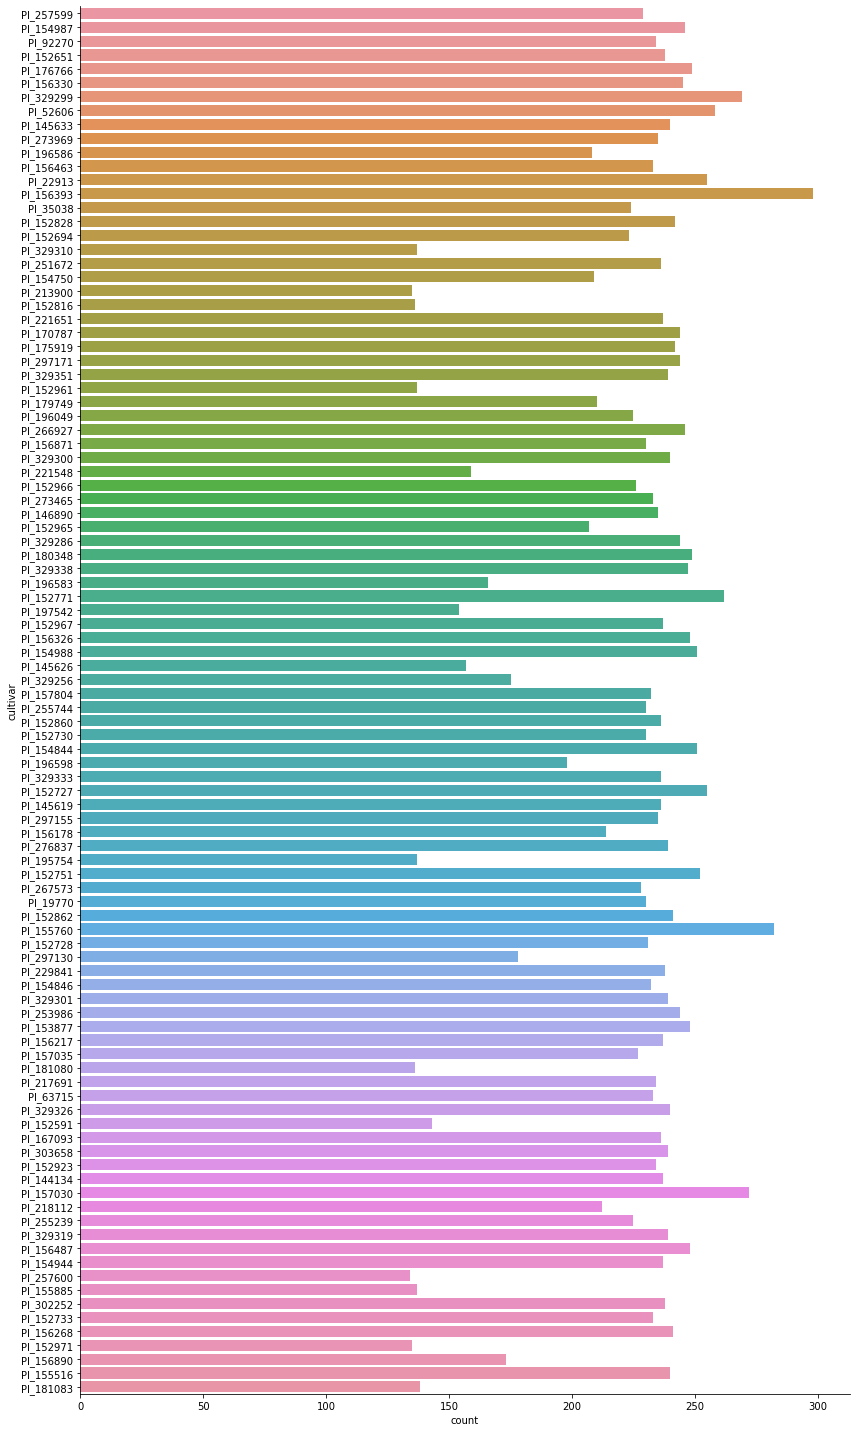

In [17]:
sns.catplot(data=image_df,kind='count',y='cultivar', height=20, aspect=0.6)
plt.show()

In [18]:
splits = 1

if splits==1:
    train_df = image_df
    val_df = pd.DataFrame(columns=train_df.columns)
else:
    kfold = StratifiedKFold(n_splits=2, shuffle=True)
    for train_index, valid_index in kfold.split(image_df['image'],image_df['cultivar']):
        train_images, valid_images = image_df['image'].iloc[train_index], image_df['image'].iloc[valid_index]
        train_cultivar, valid_cultivar = image_df['cultivar'].iloc[train_index], image_df['cultivar'].iloc[valid_index]

    train_df= pd.DataFrame({'image':train_images, 'cultivar':train_cultivar})
    val_df= pd.DataFrame({'image':valid_images, 'cultivar':valid_cultivar})

len(train_df), len(val_df)

(22193, 0)

In [19]:
train_df

image   cultivar
0      2017-06-16__12-24-20-930.png  PI_257599
1      2017-06-02__16-48-57-866.png  PI_154987
2      2017-06-12__13-18-07-707.png   PI_92270
3      2017-06-22__13-18-06-841.png  PI_152651
4      2017-06-26__12-56-48-642.png  PI_176766
...                             ...        ...
22189  2017-06-16__12-27-16-266.png  PI_170787
22190  2017-06-28__11-19-57-454.png  PI_156393
22191  2017-06-28__10-20-32-417.png  PI_152923
22192  2017-06-28__12-47-02-714.png  PI_257599
22193  2017-06-04__13-12-56-053.png  PI_196586

[22193 rows x 2 columns]

In [20]:
val_df

Empty DataFrame
Columns: [image, cultivar]
Index: []

In [21]:
def clahe(img):
    c = cv.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    t = np.asarray(img)
    t = cv.cvtColor(t, cv.COLOR_BGR2HSV)
    t[:,:,-1] = c.apply(t[:,:,-1])
    t = cv.cvtColor(t, cv.COLOR_HSV2BGR)
    t = Img.fromarray(t)
    t = np.array(t)
    return t

class CLAHE(ImageOnlyTransform):
    def apply(self, img, **params):
        return clahe(img)

def normalise(img):
    t = np.array(img,dtype=np.float32)/255
    return t

class NORMALISE(ImageOnlyTransform):
    def apply(self, img, **params):
        return normalise(img)


In [22]:
def get_transforms(phase: str):
    if phase == "train":
        return Compose([
                CLAHE(p=1),
                A.RandomResizedCrop(height=HEIGHT, width=WIDTH),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16,
                                    max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                
        ])
    else:
        return Compose([
                CLAHE(p=1),
                A.Resize(height=HEIGHT, width=WIDTH),
        ])



In [23]:
train_datagen = ImageDataAugmentor(augment=get_transforms("train"))
val_datagen = ImageDataAugmentor(augment=get_transforms("val"))

In [24]:
train_augmented = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    shuffle=True,
    directory=TRAIN_DIR,
    x_col='image',
    y_col='cultivar',
    class_mode='categorical',
    target_size=(HEIGHT,WIDTH),
    batch_size=batch_size)

Found 22193 validated image filenames belonging to 100 classes.


In [25]:
if not val_df.empty:
    val_augmented = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        shuffle=True,
        directory=TRAIN_DIR,
        x_col='image',
        y_col='cultivar',
        class_mode='categorical',
        target_size=(HEIGHT,WIDTH),
        batch_size=batch_size)

In [26]:
num_classes = len(train_augmented.class_indices)

In [27]:
class_id, num_images = np.unique(train_augmented.classes,return_counts=True)
max_value = max(num_images)
class_weights = {c : max_value/n for c,n in zip(class_id, num_images)}

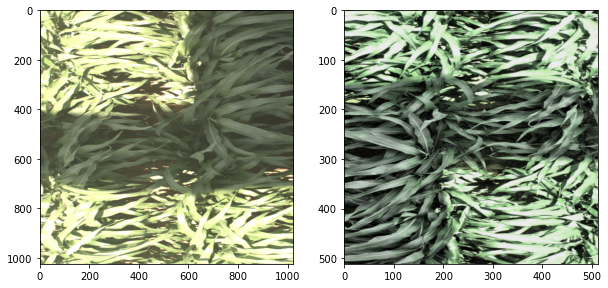

34 255
0 236


In [28]:
image = cv2.imread("/mnt/shared/scratch/fmacfarl/datasets/sorghum-id-fgvc-9/train_images/2017-06-05__13-04-59-234.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed_image = get_transforms("train")(image=image)["image"]

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
ax.grid(False)
plt.imshow(image)
ax = plt.subplot(1, 2, 2)
ax.grid(False)
plt.imshow(transformed_image)
plt.show()

print(np.min(image),np.max(image))
print(np.min(transformed_image),np.max(transformed_image))

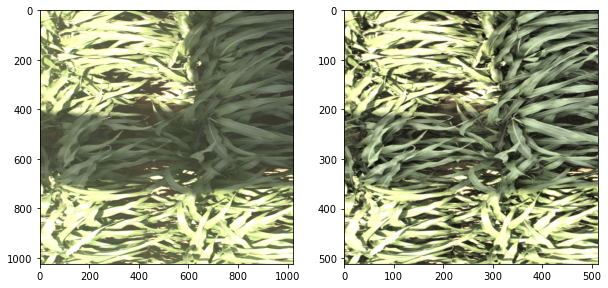

34 255
4 255


In [29]:
image = cv2.imread("/mnt/shared/scratch/fmacfarl/datasets/sorghum-id-fgvc-9/train_images/2017-06-05__13-04-59-234.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed_image = get_transforms("val")(image=image)["image"]

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
ax.grid(False)
plt.imshow(image)
ax = plt.subplot(1, 2, 2)
ax.grid(False)
plt.imshow(transformed_image)
plt.show()

print(np.min(image),np.max(image))
print(np.min(transformed_image),np.max(transformed_image))


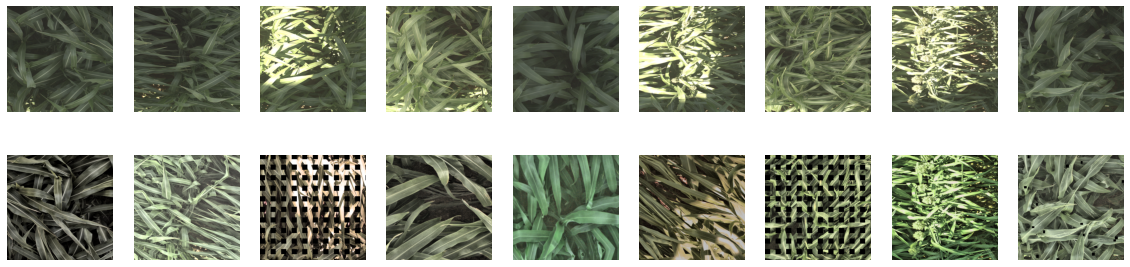

In [30]:
df = image_df.sample(9)

plt.figure(figsize=(20, 5))
for i in range(9):
    
    img_path = TRAIN_DIR+str(df["image"].values[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    transformed_image = get_transforms("train")(image=img)["image"]

    ax = plt.subplot(2, 9, i + 1)
    plt.imshow(img)
    plt.axis("off")
    ax = plt.subplot(2, 9, i + 10)
    plt.imshow(transformed_image)
    plt.axis("off")




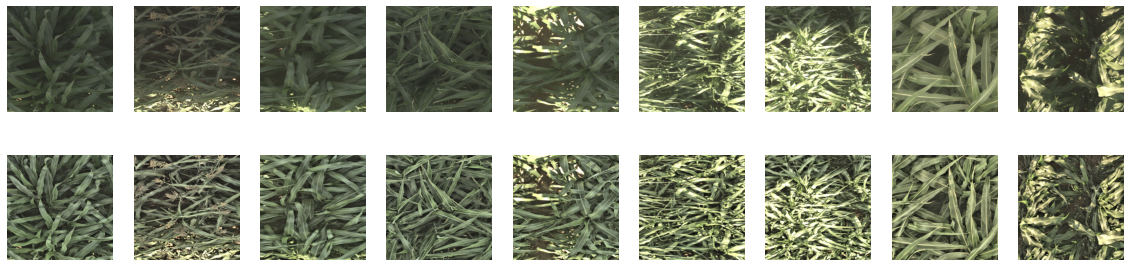

In [31]:
df = image_df.sample(9)

plt.figure(figsize=(20, 5))
for i in range(9):
    
    img_path = TRAIN_DIR+str(df["image"].values[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    transformed_image = get_transforms("val")(image=img)["image"]

    ax = plt.subplot(2, 9, i + 1)
    plt.imshow(img)
    plt.axis("off")
    ax = plt.subplot(2, 9, i + 10)
    plt.imshow(transformed_image)
    plt.axis("off")


In [32]:
def create_model():

    tf.keras.backend.clear_session()

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        backbone = efficientnet.EfficientNetV2XL(input_shape=(512, 512, 3), include_preprocessing=False, num_classes=0)
        inputs = tf.keras.Input(shape=(512, 512, 3))
        x = backbone(inputs)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(100, activation="softmax", dtype='float32')(x)
        model = tf.keras.Model(inputs, outputs)

        model.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            metrics=[tf.keras.metrics.CategoricalAccuracy(),
                                    tf.keras.metrics.Precision(),
                                    tf.keras.metrics.Recall(),
                                    tfa.metrics.F1Score(average='macro', num_classes=100),
                                    ])

    model.summary()
    return model

model = create_model()

Number of devices: 2
>>>> Load pretrained from: /home/fmacfarl/.keras/models/efficientnetv2/efficientnetv2-xl-21k-ft1k.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 efficientnet_v2-xl (Functio  (None, 16, 16, 1280)     207615832 
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
     

In [33]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=7,
                   verbose=1,
                   restore_best_weights=True)

cp = ModelCheckpoint(save_dir + 'effnetB4-{epoch:04d}.ckpt',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     save_weights_only=False,
                     mode='min' )

sv = ModelCheckpoint(model_dir + 'effnetB4-{epoch:04d}.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=False,
                     save_weights_only=False,
                     mode='min' )

sv_best = ModelCheckpoint(model_dir + 'effnetB4-optimal.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     save_weights_only=False,
                     mode='min' )

csv = tf.keras.callbacks.CSVLogger('../history/'+TASK_ID+'.csv')

tb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.4,
                                                 verbose=1,
                                                 patience=2, 
                                                 min_lr=1e-6)

In [34]:
STEP_SIZE_TRAIN = train_augmented.n//train_augmented.batch_size
if not val_df.empty:
    STEP_SIZE_VALID = val_augmented.n//val_augmented.batch_size

In [37]:
epoch=5

In [38]:
%%time
if not val_df.empty:
    history = model.fit(train_augmented,
                    epochs=epoch,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    callbacks=[es,tb,sv,sv_best,reduce_lr,csv],
                    verbose=1,
                    class_weight=class_weights,
                    validation_data=val_augmented,
                    validation_steps=STEP_SIZE_VALID)

else:
    history = model.fit(train_augmented,
                    epochs=epoch,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    callbacks=[es,tb,sv,sv_best,reduce_lr,csv],
                    verbose=1,
                    class_weight=class_weights)


Epoch 1/5
2774/2774 [==============================] - ETA: 0s - loss: 3.0247 - categorical_accuracy: 0.3933 - precision: 0.7255 - recall: 0.1992 - f1_score: 0.3955
Epoch 1: saving model to ../models/sorghum-id-20220509-053846/effnetB4-0001.h5
2774/2774 [==============================] - 2110s 757ms/step - loss: 3.0247 - categorical_accuracy: 0.3933 - precision: 0.7255 - recall: 0.1992 - f1_score: 0.3955 - lr: 1.0000e-04
Epoch 2/5
2774/2774 [==============================] - ETA: 0s - loss: 2.1975 - categorical_accuracy: 0.5388 - precision: 0.7912 - recall: 0.3731 - f1_score: 0.5433
Epoch 2: saving model to ../models/sorghum-id-20220509-053846/effnetB4-0002.h5
2774/2774 [==============================] - 2110s 760ms/step - loss: 2.1975 - categorical_accuracy: 0.5388 - precision: 0.7912 - recall: 0.3731 - f1_score: 0.5433 - lr: 1.0000e-04
Epoch 3/5
2774/2774 [==============================] - ETA: 0s - loss: 1.7283 - categorical_accuracy: 0.6328 - precision: 0.8282 - recall: 0.4911 - f1

In [39]:
backbone = efficientnet.EfficientNetV2XL(input_shape=(512, 512, 3), include_preprocessing=False, num_classes=0)


>>>> Load pretrained from: /home/fmacfarl/.keras/models/efficientnetv2/efficientnetv2-xl-21k-ft1k.h5


In [41]:
backbone.summary()

 ...]